# 13장. 텍스트마이닝_감성분석과 토픽분석

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd

# 1부. 감성 분류 모델 구축

## 1. 데이터 수집

#### 깃허브에서 데이터 파일 다운로드 : https://github.com/e9t/nsmc 

## 2. 데이터 준비 및 탐색

### 2-1) 훈련용 데이터 준비

#### (1) 훈련용 데이터 파일 로드

In [2]:
nsmc_train_df = pd.read_csv('./13장_data/ratings_train.txt', encoding='utf8', sep='\t', engine='python')
nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


#### (2) 데이터의 정보 확인

In [3]:
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


#### (3) 'document'칼럼이 Null인 샘플 제거

In [4]:
nsmc_train_df = nsmc_train_df[nsmc_train_df['document'].notnull()]

In [5]:
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


#### (4) 타겟 컬럼 label 확인 (0: 부정감성,   1: 긍정감성)

In [6]:
nsmc_train_df['label'].value_counts()

label
0    75170
1    74825
Name: count, dtype: int64

#### (5) 한글 이외의 문자는 공백으로 변환 (정규표현식 이용)

In [7]:
import re

In [8]:
nsmc_train_df['document'] = nsmc_train_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
nsmc_train_df.head()  #작업 확인용 출력

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2-2) 평가용 데이터 준비

#### (1) 평가용 데이터 파일 로드

In [9]:
nsmc_test_df = pd.read_csv('./13장_data/ratings_test.txt', encoding='utf8', sep='\t', engine='python')
nsmc_test_df.head() #작업 확인용 출력

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


#### (2) 데이터의 정보 확인

In [10]:
nsmc_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


#### (3) 'document'칼럼이 Null인 샘플 제거

In [11]:
nsmc_test_df = nsmc_test_df[nsmc_test_df['document'].notnull()]

#### (4) 타겟 컬럼 label 확인 (0: 부정감성, 1: 긍정감성)

In [12]:
nsmc_test_df['label'].value_counts()

label
1    25171
0    24826
Name: count, dtype: int64

#### (5) 한글 이외의 문자는 공백으로 변환 (정규표현식 이용)

In [13]:
nsmc_test_df['document'] = nsmc_test_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', "", x))

## 3. 분석 모델 구축

### 3-1) 피처 벡터화 : TF-IDF

#### (1) 형태소를 분석하여 토큰화 : 한글 형태소 엔진으로 Okt 이용

In [ ]:
!pip install konlpy

In [14]:
from konlpy.tag import Okt

okt = Okt()

In [15]:
def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens

#### (2) TF-IDF 기반 피처 벡터 생성 : 실행시간 10분 정도 걸립니다 ☺

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9, token_pattern=None)
tfidf.fit(nsmc_train_df['document'])
nsmc_train_tfidf = tfidf.transform(nsmc_train_df['document'])

### 3-2) 감성 분류 모델 구축 : 로지스틱 회귀를 이용한 이진 분류

### - Sentiment Analysis using Logistic Regression

#### (1) 로지스틱 회귀 기반 분석모델 생성

In [17]:
from sklearn.linear_model import LogisticRegression

SA_lr = LogisticRegression(random_state = 0,  max_iter=500)

In [18]:
SA_lr.fit(nsmc_train_tfidf, nsmc_train_df['label'])

LogisticRegression(max_iter=500, random_state=0)

#### (2) 로지스틱 회귀의  best 하이퍼파라미터 찾기

In [19]:
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 3, 3.5, 4, 4.5, 5]}
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid=params, cv=3, scoring='accuracy', verbose=1)

#### (3) 최적 분석 모델 훈련

In [20]:
SA_lr_grid_cv.fit(nsmc_train_tfidf, nsmc_train_df['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500, random_state=0),
             param_grid={'C': [1, 3, 3.5, 4, 4.5, 5]}, scoring='accuracy',
             verbose=1)

In [21]:
print(SA_lr_grid_cv.best_params_, round(SA_lr_grid_cv.best_score_, 4))

{'C': 3} 0.8553


In [22]:
# 최적 파라미터의 best 모델 저장
SA_lr_best = SA_lr_grid_cv.best_estimator_

## 4. 분석 모델 평가

### 4-1) 평가용 데이터를 이용하여 감성 분석 모델 정확도

In [23]:
# 평가용 데이터의 피처 벡터화 : 실행시간 6분 정도 걸립니다 ☺
nsmc_test_tfidf = tfidf.transform(nsmc_test_df['document'])

In [24]:
test_predict = SA_lr_best.predict(nsmc_test_tfidf)

In [25]:
from sklearn.metrics import accuracy_score

print('감성 분석 정확도 : ', round(accuracy_score(nsmc_test_df['label'], test_predict), 3))

감성 분석 정확도 :  0.857


### 4-2) 새로운 텍스트에 대한 감성 예측

In [26]:
st = input('감성 분석할 문장입력 >> ')

감성 분석할 문장입력 >> 웃자 ^o^ 오늘은 좋은 날이 될 것 같은 예감100%! ^^*


In [27]:
# 0) 입력 텍스트에 대한 전처리 수행
st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(st)
print(st)
st = [" ".join(st)]
print(st)

['웃자', '오늘은', '좋은', '날이', '될', '것', '같은', '예감']
['웃자 오늘은 좋은 날이 될 것 같은 예감']


In [28]:
# 1) 입력 텍스트의 피처 벡터화
st_tfidf = tfidf.transform(st)

# 2) 최적 감성분석 모델에 적용하여 감성 분석 평가
st_predict = SA_lr_best.predict(st_tfidf)

In [29]:
# 3) 예측 값 출력하기
if(st_predict== 0):
    print(st , "->> 부정 감성")
else :
    print(st , "->> 긍정 감성")

['웃자 오늘은 좋은 날이 될 것 같은 예감'] ->> 긍정 감성


# 2부. 감성 분석 수행 

## 1. 감성 분석할 데이터 수집

#### - 4장에서 학습한 네이버 API를 이용한 크롤링 프로그램을 이용, 네이버 뉴스를 크롤링하여 텍스트 데이터를 수집한다

## 2. 데이터 준비 및 탐색

#### (1) 파일 불러오기

In [30]:
import json

file_name = '코로나_naver_news'

with open('./13장_data/'+file_name+'.json', encoding='utf8') as j_f:
    data = json.load(j_f)

In [31]:
print(data)

[{'cnt': 1, 'description': '<b>코로나</b>발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만, 국세 수입은 줄어들면서 정부의 재정 마련에 대한 우려가 컸다. 이 때문에 한국개발원(KDI) 등 국책연구기관들은 증세를 화두로 꺼내들었지만, 정부 여당은 증세에... ', 'pDate': '2020-06-04 14:12:00', 'title': "결국 '증세론' 먼저 꺼내든 與…&quot;증세없는 '기본소득' 불가능&quot;"}, {'cnt': 2, 'description': '▲ 지난 2일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다.©(사진제공=창녕군청) <b>코로나</b> 장기화 대비 비대면 선별진료 도입 경남 창녕군은 지난 2월 28일 도내 최초로 <b>코로나</b>19 선별진료소... ', 'pDate': '2020-06-04 14:12:00', 'title': '창녕군, ‘창녕형’비대면 선별진료소 운영'}, {'cnt': 3, 'description': "한편, ‘설현’은 최근 <b>코로나</b>19 바이러스를 다룬, MBC ‘시리즈M’ PANDEMIC(세계적 유행)에서 다큐멘터리 내레이션에 처음 도전해 호평을 받았으며, tvN의 새 드라마 '낮과 밤' 출연을 검토중이다. 게임과 이벤트에 대한... ", 'pDate': '2020-06-04 14:12:00', 'title': "DK모바일, 메인 홍보 모델로 AOA '설현' 선정"}, {'cnt': 4, 'description': '변화의 핵심 중에서는 우리 사회가 신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19)의 위기를 마주하고 있다. 언제 끝이날 지 또 앞으로 어떠한 미래가 펼치질 지 모른다. 국가가 나서서 국민의 어려움을 해결해 줘야 한다. 저희... ', 'pDate': '2020-06-04 14:12:00', 'title': '김병민 &quot;기본소득도 필요하면 논의 테이블에 올려야&quot; [인터뷰]'}, {'cnt': 5, 

#### (2) 분석할 컬럼을 추출하여 데이터 프레임에 저장

In [32]:
data_title =[]
data_description = []

for item in data:
    data_title.append(item['title'])
    data_description.append(item['description'])

In [33]:
data_title

["결국 '증세론' 먼저 꺼내든 與…&quot;증세없는 '기본소득' 불가능&quot;",
 '창녕군, ‘창녕형’비대면 선별진료소 운영',
 "DK모바일, 메인 홍보 모델로 AOA '설현' 선정",
 '김병민 &quot;기본소득도 필요하면 논의 테이블에 올려야&quot; [인터뷰]',
 '이재갑 장관, 고용안정지원금 서울센터 방문',
 "'부산행'→'반도'로 이어지는 한국형 좀비 세계관, 칸의 선택 받았다",
 "31년만 첫 '불허'에도 홍콩, 톈안문 추모 촛불",
 '국내 3대 항만 4월 물동량 ‘인천항만 상승곡선’',
 '경기도의회 농정해양위, 농민기본소득 도입 이재명 지사와 집행부에 강력 촉구',
 '이용빈 원내부대표 &quot;<b>코로나</b> 대응 의료진·노동자 건강권 보장해야&quot;',
 '<b>코로나</b>19로 인해 변한 원광한의대 경혈학 실습 풍경',
 '경산시 농산물 드라이브 스루 특별할인 판매행사 개최',
 '당신이 아는 미술, 시장이 아는 미술 ④ 한국 현대 미술 시장을 이끄는 작가',
 '제25회 부산국제영화제 공식 상영작 모집 [공식]',
 '수도권 <b>코로나</b>19 확진자 산발적으로 늘어…하루 새 47명 증가',
 '동작구, 전통시장 무료 배송서비스 사업 실시',
 '서울 건강용품 세미나서 무더기 확진…199명 검사',
 'BBQ, 상반기 신입 및 경력직 공채 시행',
 '중국 굴착기 판매량 상승에도...두산인프라코어 긴장하는 이유는',
 '미소짓는 의료진',
 "'포스트 <b>코로나</b>' 대비…M&amp;A·투자 잰걸음 나서는 게임사",
 "휴넷, 리더십 게임러닝 프로그램 '아르고' 출시",
 '광주 서구 양동, 민·관 협력으로 주거환경 개선',
 '손흥민의 고백, “3주간의 군사훈련, 힘들지만 즐겼다”',
 '靑 “카타르 LNG선 수주, 문 대통령 경제외교 결실”',
 '[유통÷나누기 세상＋더하기] 세븐일레븐, 유치원 통학차량에 공기청정기 설치...',
 '김포 혁신교육지구 사업, 특수교육대상자를 위한 교육과정 지원'

In [34]:
data_description

['<b>코로나</b>발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만, 국세 수입은 줄어들면서 정부의 재정 마련에 대한 우려가 컸다. 이 때문에 한국개발원(KDI) 등 국책연구기관들은 증세를 화두로 꺼내들었지만, 정부 여당은 증세에... ',
 '▲ 지난 2일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다.©(사진제공=창녕군청) <b>코로나</b> 장기화 대비 비대면 선별진료 도입 경남 창녕군은 지난 2월 28일 도내 최초로 <b>코로나</b>19 선별진료소... ',
 "한편, ‘설현’은 최근 <b>코로나</b>19 바이러스를 다룬, MBC ‘시리즈M’ PANDEMIC(세계적 유행)에서 다큐멘터리 내레이션에 처음 도전해 호평을 받았으며, tvN의 새 드라마 '낮과 밤' 출연을 검토중이다. 게임과 이벤트에 대한... ",
 '변화의 핵심 중에서는 우리 사회가 신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19)의 위기를 마주하고 있다. 언제 끝이날 지 또 앞으로 어떠한 미래가 펼치질 지 모른다. 국가가 나서서 국민의 어려움을 해결해 줘야 한다. 저희... ',
 '\xa0이재갑\xa0고용노동부\xa0장관은\xa06월3일(수)\xa011시에\xa0<b>코로나</b>19\xa0긴급\xa0고용안정지원금\xa0서울\xa01센터(서울\xa0중구)를\xa0방문했다. 이번\xa0현장\xa0방문은\xa0<b>코로나</b>19\xa0긴급\xa0고용안정지원금\xa0신청을\xa0시작한\xa0지\xa0이틀\xa0만에\xa0약\xa012만건... ',
 "하지만 올해 신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19) 여파로 오프라인 행사를 진행하지 않게 되었고, 공식 채널(Canal +)을 통해 ‘Cannes Official Selection 2020’ 명칭의 초청작 리스트를 공개했다. 한편 '반도'는 7월 국내외... ",
 '경찰은 <b>코로나</b>19 감염이 우려된다며 8명 이상을 모이는 집회를 봉쇄해왔고 지난 홍콩 국가보안법

In [35]:
data_df = pd.DataFrame({'title':data_title, 'description':data_description})

#### (3) 한글 이외 문자 제거

In [36]:
data_df['title'] = data_df['title'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
data_df['description'] = data_df['description'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))

data_df.head()  #작업 확인용 출력

,title,description
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 ...
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...


## 3. 감성 분석 수행

### 3-1) 'title'에 대한 감성 분석

In [37]:
# 1) 분석할 데이터의 피처 벡터화 ---<< title >> 분석
data_title_tfidf = tfidf.transform(data_df['title'])

# 2) 최적 파라미터 학습모델에 적용하여 감성 분석
data_title_predict = SA_lr_best.predict(data_title_tfidf)

# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['title_label'] = data_title_predict

### 3-2) 'description' 에 대한 감성 분석

In [38]:
# 1) 분석할 데이터의 피처 벡터화 ---<< description >> 분석
data_description_tfidf = tfidf.transform(data_df['description'])

# 2) 최적 파라미터 학습모델에 적용하여 감성 분석
data_description_predict = SA_lr_best.predict(data_description_tfidf)

# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['description_label'] = data_description_predict

### 3-3)  분석 결과가 추가된 데이터프레임을 CSV 파일 저장

In [39]:
# csv 파일로 저장 ---------------------------------------------
data_df.to_csv('./13장_data/'+file_name+'.csv', encoding='euc-kr') 

## 4. 감성 분석 결과 확인 및 시각화 - 0: 부정감성,   1: 긍정감성

### 4-1) 감성 분석 결과 확인

In [40]:
data_df.head()

,title,description,title_label,description_label
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...,0,0
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...,0,0
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...,0,0
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 ...,0,1
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...,0,0


In [41]:
print(data_df['title_label'].value_counts())

title_label
0    485
1    315
Name: count, dtype: int64


In [42]:
print(data_df['description_label'].value_counts())

description_label
0    430
1    370
Name: count, dtype: int64


### 4-2) 결과 저장 : 긍정과 부정을 분리하여 CSV 파일 저장

In [43]:
columns_name = ['title','title_label','description','description_label']
NEG_data_df = pd.DataFrame(columns=columns_name)
POS_data_df = pd.DataFrame(columns=columns_name)

for i, data in data_df.iterrows(): 
    title = data["title"] 
    description = data["description"] 
    t_label = data["title_label"] 
    d_label = data["description_label"] 
    
    if d_label == 0: # 부정 감성 샘플만 추출
        NEG_data_df = pd.concat([NEG_data_df,pd.DataFrame([[title,t_label,description,d_label]],columns=columns_name)],ignore_index=True)
    else : # 긍정 감성 샘플만 추출
        POS_data_df = pd.concat([POS_data_df,pd.DataFrame([[title,t_label,description,d_label]],columns=columns_name)],ignore_index=True)
     
# 파일에 저장.
NEG_data_df.to_csv('./13장_data/'+file_name+'_NEG.csv', encoding='euc-kr') 
POS_data_df.to_csv('./13장_data/'+file_name+'_POS.csv', encoding='euc-kr') 

In [44]:
len(NEG_data_df), len(POS_data_df)

(430, 370)

### 4-3)  감성 분석 결과 시각화 : 바 차트

#### (1) 명사만 추출하여 정리하기

#### - 긍정 감성의 데이터에서 명사만 추출하여 정리 

In [45]:
POS_description = POS_data_df['description']

In [46]:
POS_description_noun_tk = []

for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출

In [47]:
print(POS_description_noun_tk)  #작업 확인용 출력

[['변화', '핵심', '중', '우리', '사회', '신종', '코로나', '바이러스', '감염증', '코로나', '의', '위기', '마주', '언제', '끝', '날', '또', '앞', '미래', '국가', '국민', '어려움', '해결', '저희'], ['한편', '코로나', '로', '해외', '식', '재료', '사재기', '국민', '먹거리', '안정', '생산', '것', '포스트', '코로나', '의', '과제', '부각', '농민', '기본소득', '도입', '통해', '안정', '생산', '기반', '확충', '것'], ['최근', '갤러리', '현대', '창업', '주년', '기념', '전', '이', '작품', '전시', '코로나', '의', '영향', '마스크', '착용', '관람객', '미술', '트렌드', '한국', '미술', '시장', '글', '정태희', '서울', '옥션', '스페셜리스트', '세계', '경기', '침체', '코로나', '여파'], ['코로나', '감안', '차', '면접', '비대', '역량', '검사', '도입', '국내', '최대', '치킨', '프랜차이즈', '제너시스', '비비큐', '회장', '채용', '관계자', '한국', '대표', '책임감', '브랜드', '로서', '코로나', '로', '침체', '채용', '분위기'], ['일', '오후', '서울', '중랑구', '의료', '의료', '잠시', '콘서트', '신종', '코로나', '바이러스', '감염증', '코로나', '환자', '진료', '위해', '수고', '온', '의료', '진', '가수', '폴', '킴', '공연', '보고', '뉴스'], ['플립', '러닝', '온라인', '학습', '후', '교실', '토론', '및', '심화', '학습', '거꾸로', '교실', '불리', '포스트', '코로나', '시대', '교육', '방식', '주목', '아르고', '리더십', '편', '상황', '게임', '통해', '리더십', '유형

In [48]:
POS_description_noun_join = []

for d in POS_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1인 토큰은 제외
    POS_description_noun_join.append(" ".join(d2)) # 토큰을 연결(join)하여 리스트 구성

In [49]:
print(POS_description_noun_join)  #작업 확인용 출력

['변화 핵심 우리 사회 신종 코로나 바이러스 감염증 코로나 위기 마주 언제 미래 국가 국민 어려움 해결 저희', '한편 코로나 해외 재료 사재기 국민 먹거리 안정 생산 포스트 코로나 과제 부각 농민 기본소득 도입 통해 안정 생산 기반 확충', '최근 갤러리 현대 창업 주년 기념 작품 전시 코로나 영향 마스크 착용 관람객 미술 트렌드 한국 미술 시장 정태희 서울 옥션 스페셜리스트 세계 경기 침체 코로나 여파', '코로나 감안 면접 비대 역량 검사 도입 국내 최대 치킨 프랜차이즈 제너시스 비비큐 회장 채용 관계자 한국 대표 책임감 브랜드 로서 코로나 침체 채용 분위기', '오후 서울 중랑구 의료 의료 잠시 콘서트 신종 코로나 바이러스 감염증 코로나 환자 진료 위해 수고 의료 가수 공연 보고 뉴스', '플립 러닝 온라인 학습 교실 토론 심화 학습 거꾸로 교실 불리 포스트 코로나 시대 교육 방식 주목 아르고 리더십 상황 게임 통해 리더십 유형', '도배 장판 침대 장롱 가구 교체 코로나 예방 방역 진행 주거 환경 조성 미자 양동 동장 이웃 위해 봉사', '코로나 사태 가운데 병영 생활 손흥민 경험 영국 화제 손흥민 서로 금방 이서 정말 서로 호흡', '청와대 해외 보가 문재인 대통령 포스트 코로나 시대 경제위기 정상회담 통해 양국 협력 에너지 의료 확장 최근 카타르 코로나 관련', '맥도날드 코로나 방역 작업 대구 지하철 청소 근로자 빅맥 커피 증정 패션 업계 나눔 활동 동참 코오롱 인더스 트리 직원 성과 상금 만원 코로나 어려움', '정하영 김포시 혁신 교육 지구 사업 특수교육 대상자 사업 별도 편성 소외 학생 면서 코로나 교육과정 운영 판단 학생 안전 방역', '군포 시청 서울시 리치 웨이 코로나 진자 동선 공개 군포로 번길 거주 자료 군포 시청 군포 시청 서울시 리치 웨이 코로나 진자 동선 공개 군포 시청 공식 블로그 통해 서울시', '명품 함양 양파 특판전 모습 사진 제공 함양군 함양군 롯데 마트 서울 역점 양파 소비 촉진 판촉 행사 코로나 농심 위로 함양군

#### - 부정 감성의 데이터에서 명사만 추출하여 정리 

In [50]:
NEG_description = NEG_data_df['description']

NEG_description_noun_tk = []
NEG_description_noun_join = []

for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출
    
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1]  #길이가 1인 토큰은 제외
    NEG_description_noun_join.append(" ".join(d2)) # 토큰을 연결(join)하여 리스트 구성

#### (2) dtm 구성 : 단어 벡터 값을 내림차순으로 정렬

#### - 긍정 감성 데이터에 대한 dtm 구성, dtm을 이용하여 단어사전 구성 후 내림차순 정렬

In [51]:
POS_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

In [52]:
POS_vocab = dict() 

for idx, word in enumerate(POS_tfidf.get_feature_names_out()):
    POS_vocab[word] = POS_dtm.getcol(idx).sum()
    
POS_words = sorted(POS_vocab.items(), key=lambda x: x[1], reverse=True)

In [53]:
POS_words  #작업 확인용 출력

[('코로나', 29.58865817494428),
 ('의료', 13.461836434575911),
 ('위해', 11.469142512665115),
 ('바이러스', 9.626197092990505),
 ('신종', 9.241355937335499),
 ('감염증', 8.876275469712054),
 ('온라인', 7.6638009611810896),
 ('시대', 7.638747100423279),
 ('확산', 7.462304300911354),
 ('사회', 7.331187766652533),
 ('이번', 6.953637262299177),
 ('지역', 6.7931464306235565),
 ('어려움', 6.57884559465247),
 ('통해', 6.500569971401247),
 ('극복', 6.067323212381158),
 ('포스트', 6.02648184365831),
 ('기업', 5.899827006908783),
 ('서울', 5.432782197187217),
 ('사태', 5.340689961243574),
 ('방역', 5.308659591090857),
 ('최근', 5.285143543921558),
 ('언택트', 5.185701361355053),
 ('상황', 5.129043847943381),
 ('환자', 5.111079129368619),
 ('정부', 5.069719087512996),
 ('사업', 5.045688264465154),
 ('경제', 5.043712031592348),
 ('생활', 5.034230080207947),
 ('대표', 5.031840422108942),
 ('올해', 5.011379038211078),
 ('공연', 4.936538589036854),
 ('우리', 4.898794126455551),
 ('비대', 4.802827030463792),
 ('한국', 4.770201020213962),
 ('개발', 4.767977722488553),
 ('진자', 4.

#### - 부정 감성 데이터의 dtm 구성, dtm을 이용하여 단어사전 구성 후 내림차순 정렬

In [54]:
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)

In [55]:
NEG_vocab = dict() 

for idx, word in enumerate(NEG_tfidf.get_feature_names_out()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
    
NEG_words = sorted(NEG_vocab.items(), key=lambda x: x[1], reverse=True)

In [56]:
NEG_words   #작업 확인용 출력

[('코로나', 34.56440043805242),
 ('바이러스', 15.755970871602138),
 ('신종', 14.29640382643984),
 ('감염증', 14.034156174169826),
 ('위해', 11.557221696267494),
 ('확산', 9.566148700015386),
 ('대종상영화제', 9.131196736061566),
 ('사태', 8.511012953112722),
 ('진행', 8.501455300356248),
 ('지역', 8.02051798313098),
 ('방역', 7.786170139849359),
 ('지난', 7.563662184925654),
 ('참석', 7.320037542811409),
 ('진자', 7.019841914588245),
 ('이번', 6.942817107419809),
 ('여파', 6.7290204781835925),
 ('감염', 6.669203919601509),
 ('지원', 6.501810225977662),
 ('예방', 6.39663153382676),
 ('경제', 5.6993577091405525),
 ('최근', 5.577762429272219),
 ('서울', 5.119380466737213),
 ('생활', 5.040220383692727),
 ('마스크', 4.990391941347541),
 ('대응', 4.958683224918504),
 ('장기', 4.865605387946561),
 ('가운데', 4.806733078391168),
 ('정부', 4.690520671438856),
 ('상황', 4.67552454891047),
 ('시장', 4.660874586002851),
 ('어려움', 4.633706079944705),
 ('발생', 4.558656374995721),
 ('로봇', 4.52985529979186),
 ('운영', 4.52088415417818),
 ('위기', 4.498382001461058),
 ('클라우드',

#### (3) 단어사전의 상위 단어로 바 차트 그리기

In [57]:
import matplotlib
import matplotlib.pyplot as plt

plt.rc('font', family='Malgun Gothic')  #한글폰트 설정


max = 15  #바 차트에 나타낼 단어의 수 

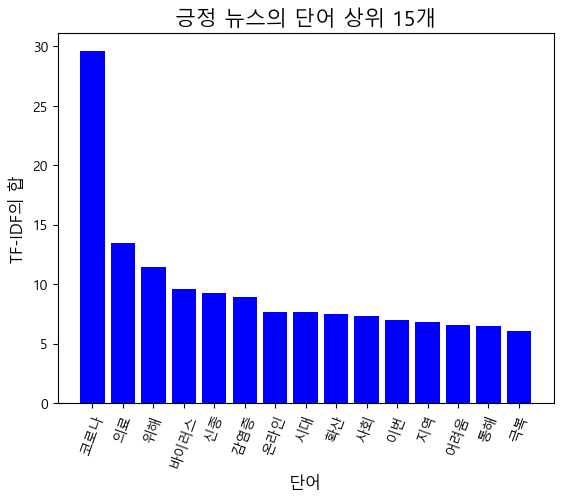

In [58]:
plt.bar(range(max), [i[1] for i in POS_words[:max]], color="blue")
plt.title("긍정 뉴스의 단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation=70)

plt.show()

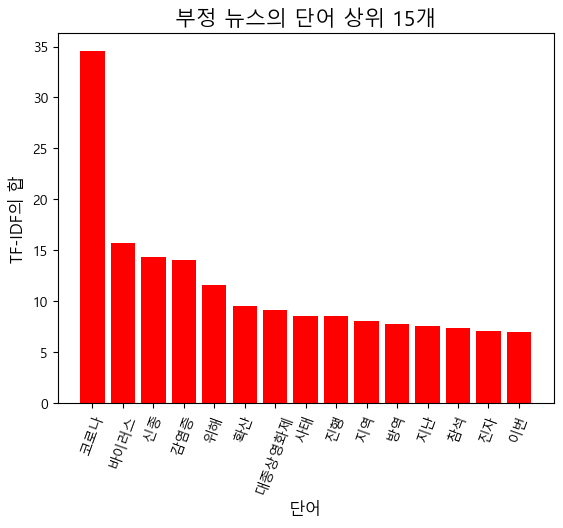

In [59]:
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color="red")
plt.title("부정 뉴스의 단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in NEG_words[:max]], rotation=70)

plt.show()

# 3부. 토픽모델링 : LDA 기반 토픽 모델링

## 1. 데이터 준비 

### 1-1) 'description' 컬럼 추출

In [60]:
description = data_df['description']

### 1-2) 형태소 토큰화 : 명사만 추출

In [61]:
description_noun_tk = []

for d in description:
    description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출

In [62]:
description_noun_tk2 = []

for d in description_noun_tk:
    item = [i for i in d if len(i) > 1]  #토큰의 길이가 1보다 큰 것만 추출
    description_noun_tk2.append(item)

In [63]:
print(description_noun_tk2) #작업 확인용 출력

[['코로나', '경제', '위기', '대응', '위해', '국세', '수입', '정부', '재정', '마련', '대한', '우려', '때문', '한국', '개발', '국책', '연구기관', '증세', '화두', '정부', '여당', '증세'], ['지난', '창녕군', '보건소', '설치', '진료', '검사', '체온', '측정', '사진', '제공', '창녕군', '코로나', '장기', '대비', '비대', '진료', '도입', '경남', '창녕군', '지난', '도내', '최초', '코로나', '진료'], ['한편', '설현', '최근', '코로나', '바이러스', '시리즈', '세계', '유행', '다큐멘터리', '내레이션', '처음', '도전', '호평', '드라마', '출연', '검토', '게임', '이벤트', '대한'], ['변화', '핵심', '우리', '사회', '신종', '코로나', '바이러스', '감염증', '코로나', '위기', '마주', '언제', '미래', '국가', '국민', '어려움', '해결', '저희'], ['이재', '고용노동부', '장관', '코로나', '긴급', '고용', '안정', '원금', '서울', '센터', '서울', '중구', '방문', '이번', '현장', '방문', '코로나', '긴급', '고용', '안정', '원금', '신청', '시작', '이틀'], ['올해', '신종', '코로나', '바이러스', '감염증', '코로나', '여파', '오프라인', '행사', '진행', '공식', '채널', '통해', '명칭', '초청', '리스트', '공개', '한편', '반도', '국내외'], ['경찰', '코로나', '감염', '우려', '이상', '집회', '봉쇄', '지난', '홍콩', '국가보안법', '시위', '홍콩', '경찰', '코로나', '확산', '올해', '불허', '상황', '처음', '주최'], ['전국', '컨테이너', '처리', '국내', '항만', '신종', '코로나', '바이러스', '감염증

## 2. LDA 토픽 모델 구축

### 2-1) LDA 모델의 입력 벡터 생성 

In [ ]:
# 최초 한번만 설치
!pip install gensim   

In [64]:
import gensim
import gensim.corpora as corpora

#### (1) 단어 사전 생성

In [65]:
dictionary = corpora.Dictionary(description_noun_tk2)

In [66]:
print(dictionary[1])  #작업 확인용 출력

경제


#### (2) 단어와 출현빈도(count)의 코퍼스 생성

In [67]:
corpus = [dictionary.doc2bow(word) for word in description_noun_tk2]

In [68]:
print(corpus) #작업 확인용 출력

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1)], [(17, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 3), (33, 3), (34, 1), (35, 1), (36, 1)], [(5, 1), (17, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)], [(12, 1), (17, 2), (43, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1)], [(17, 2), (68, 2), (69, 1), (70, 2), (71, 2), (72, 2), (73, 1), (74, 1), (75, 1), (76, 2), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1)], [(17, 2), (43, 1), (52, 1), (54, 1), (61, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1)], [(11, 1)

### 2-2) LDA 모델 생성 및 훈련 

In [69]:
k = 4  #토픽의 개수 설정

In [70]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus, iterations = 12, num_topics = k, 
                                                    id2word = dictionary, passes = 1, workers = 10)

## 3. LDA 토픽 분석 결과 시각화

### 3-1) 토픽 분석 결과 확인

In [71]:
print(lda_model.print_topics(num_topics = k, num_words = 15))

[(0, '0.060*"코로나" + 0.010*"위해" + 0.010*"바이러스" + 0.009*"신종" + 0.009*"감염증" + 0.006*"이번" + 0.005*"의료" + 0.005*"확산" + 0.005*"지역" + 0.005*"진행" + 0.005*"기업" + 0.004*"방역" + 0.004*"사태" + 0.004*"시대" + 0.004*"지난"'), (1, '0.055*"코로나" + 0.009*"신종" + 0.009*"바이러스" + 0.009*"위해" + 0.008*"감염증" + 0.007*"확산" + 0.006*"이번" + 0.005*"지역" + 0.004*"사태" + 0.004*"방역" + 0.004*"지난" + 0.004*"통해" + 0.003*"경제" + 0.003*"생활" + 0.003*"지원"'), (2, '0.060*"코로나" + 0.011*"바이러스" + 0.009*"신종" + 0.009*"감염증" + 0.008*"위해" + 0.005*"지역" + 0.005*"의료" + 0.004*"진자" + 0.004*"확산" + 0.004*"경제" + 0.004*"온라인" + 0.004*"어려움" + 0.004*"올해" + 0.004*"시대" + 0.004*"여파"'), (3, '0.071*"코로나" + 0.011*"바이러스" + 0.010*"감염증" + 0.009*"신종" + 0.007*"위해" + 0.006*"확산" + 0.005*"사태" + 0.005*"지역" + 0.004*"의료" + 0.004*"감염" + 0.004*"방역" + 0.004*"어려움" + 0.004*"장기" + 0.004*"이번" + 0.004*"진행"')]


### 3-2) 토픽 분석 결과 시각화 : pyLDAvis

In [ ]:
 #최초 한번만 설치
!pip install pyLDAvis==3.4.1

In [72]:
import pyLDAvis.gensim

lda_vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

In [73]:
pyLDAvis.display(lda_vis)

In [74]:
pyLDAvis.save_html(lda_vis, './13장_data/'+file_name+"_vis.html")